In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
pd.options.display.precision = 2
%matplotlib inline

In [31]:
resources = [
    'wood',
    'sheep',
    'rock',
    'clay',
    'wheat',
    'desert'
]
players = [
    'orange',
    'white',
    'blue'
]
expected_pips = {
    # averages at 58/5
    'rock': (58/18)*3,
    'clay': (58/18)*3,
    'wheat': (58/18)*4,
    'wood': (58/18)*4,
    'sheep': (58/18)*4,
    'desert': 0
}
resource_weighting = {
    'wheat': 1.15,
    'wood': 1,
    'sheep': 0.9,
    'rock': 1,
    'clay': 1,
    'desert': 0
}
resource_colours = {
    'wood': 'darkgreen',
    'sheep': 'lightgreen',
    'rock': 'grey',
    'clay': 'red',
    'wheat': 'orange',
    'desert': None
}
resource_occurances = {
    'rock': 3,
    'clay': 3,
    'wheat': 4,
    'wood': 4,
    'sheep': 4,
    'desert': 1
}
rolls = [2,3,3,4,4,5,5,6,6,8,8,9,9,10,10,11,11,12]
reslist = []
for res, n in resource_occurances.items():
    reslist += [res]*n

In [32]:
random.shuffle(rolls)
rolls

[6, 9, 3, 8, 11, 6, 10, 5, 4, 11, 3, 4, 9, 10, 8, 2, 12, 5]

In [33]:
legal_tiles = [
    (2,4),(4,4),(6,4),
    (1,3),(3,3),(5,3),(7,3),
    (0,2),(2,2),(4,2),(6,2),(8,2),
    (1,1),(3,1),(5,1),(7,1),
    (2,0),(4,0),(6,0)
]
legal_verts = ([(i, 5) for i in range(2, 6+3)] +
               [(i, 4) for i in range(1, 7+3)] +
               [(i, 3) for i in range(0, 8+3)] +
               [(i, 2) for i in range(0, 8+3)] +
               [(i, 1) for i in range(1, 7+3)] +
               [(i, 0) for i in range(2, 6+3)])

In [34]:
roll_map = {
    2:1,3:2,4:3,5:4,6:5,
    8:5,9:4,10:3,11:2,12:1
}

def roll_to_pips(roll):
    if roll is None:
        return 0
    if roll == 7 or roll < 2 or roll > 13:
        raise ValueError('illegal roll')
    return roll_map[roll]

In [35]:
class Tile:
    def __init__(self, x, y, resource=None, roll=None):
        if (x, y) not in legal_tiles:
            raise ValueError('{}, {} is an illegal position'.format(x, y))
        self.x = x
        self.y = y
        self.resource = resource
        self.roll = roll
        self.pips = roll_to_pips(roll)
    
    def __repr__(self):
        return 'Tile(@({},{}) {} {})'.format(self.x, self.y, self.resource, self.roll)
    
    
class Tiles:
    """Basically just a dictionary that holds tiles
    
    Gives us the ability to do a nice [] getitem, and define what happens when
    the item doesn't exist
    """
    def __init__(self, tiles):
        self.tiles = {(t.x, t.y): t for t in tiles if t is not None}
    
    def __getitem__(self, pos):
        # x, y = pos
        return self.tiles.get(pos, None)
    
    def __len__(self):
        return len(self.tiles)
    
    def __repr__(self):
        to_print = 'Tiles({}):'.format(len(self))
        for tile in self:
            to_print += '\n  {}'.format(repr(tile))
        return to_print
    
    def short_print(self):
        return ' '.join(['{} {}'.format(tile.resource, tile.roll) for tile in self])
    
    def __iter__(self):
        for (x,y), tile in self.tiles.items():
            yield tile
            
    def roll(self, roll):
        for (x,y), tile in self.tiles.items():
            if tile.roll == roll:
                yield tile

In [36]:
class Vertex:
    def __init__(self, x, y, port=None):
        if (x, y) not in legal_verts:
            raise ValueError('{}, {} is an illegal position'.format(x, y))
        self.x = x
        self.y = y
        self.settled = False
        self.citied = False
        self.blocked = False
    
    def __repr__(self):
        return 'Vertex(@({},{}))'.format(self.x, self.y)
    
    def settle(self, player):
        self.settled = player
        self.blocked = True
    
    def city(self, player):
        self.citied = player
    
    def block(self):
        self.blocked = True
    
    
class Verts:
    def __init__(self, verts):
        # maybe call this map?
        # so we'd have brd.verts.map.items():
        self.verts = {(v.x, v.y): v for v in verts if v is not None}
    
    def __getitem__(self, pos):
        # x, y = pos
        return self.verts.get(pos, None)
    
    def __len__(self):
        return len(self.verts)
    
    def __repr__(self):
        to_print = 'Verts({}):'.format(len(self))
        for vert in self:
            to_print += '\n  {}'.format(repr(vert))
        return to_print

    def __iter__(self):
        for (x,y), vert in self.verts.items():
            yield vert
    
    def nonblocked(self):
        for (x,y), vert in self.verts.items():
            if not vert.blocked:
                yield vert

In [37]:
def random_tiles():
    tiles = []
    random.shuffle(legal_tiles)
    for i, (x, y) in enumerate(legal_tiles):
        res = reslist[i]
        if res == 'desert':
            roll=None
        else:
            roll=rolls[i]
        tiles.append(Tile(x, y, resource=res, roll=roll))

    return tiles

In [38]:
class Board:
    """ a container for vertices and tiles
    
    a standard board has...
        19 tiles
            3 rock
            3 clay
            4 sheep
            4 wood
            4 wheat
            1 desert
        54 vertices
    """
    def __init__(self, tiles):
        """ tiles is a list of legal tiles
        """
        if isinstance(tiles, Tiles):
            self.tiles = tiles
        else:
            self.tiles = Tiles(tiles)

        self.verts = Verts([Vertex(x, y) for x, y in legal_verts])  # should be an empty set of tiles
        self.total_pips = {res: self.resource_pips(res) for res in resources}
        self.res_table = self.resource_table()
        
    def _six_eight_adjacent(self):
        for tile in self.tiles.roll(6):
            for t2 in self.tt(tile.x, tile.y):
                if t2.roll == 8 or t2.roll == 6:
                    return True
        for tile in self.tiles.roll(8):
            for t2 in self.tt(tile.x, tile.y):
                if t2.roll == 8 or t2.roll == 6:
                    return True
        
        return False
    
    @classmethod
    def random(cls):
        bad = True
        while bad:
            brd = cls(random_tiles())
            bad = brd._six_eight_adjacent()
        return brd

    def resource_table(self):
        table = pd.concat([
            pd.Series(expected_pips, name='expected_pips'),
            pd.Series(self.total_pips, name='total_pips')
        ], axis=1)
        table['more_than_expec'] = table['total_pips'] / table['expected_pips']
        return table

    def resource_pips(self, resource):
        """ search total pips by resource
        """
        pips = 0
        for tile in self.tiles:
            if tile.resource == resource:
                pips += tile.pips
        return pips
    
    def settle(self, x, y, player):
        self.verts[x, y].settle(player)
        for vert in self.vv(x, y):
            vert.block()

    
    # get adjacent items
    def tt(self, x, y):
        adj = [
            self.tiles[x+2, y],
            self.tiles[x-2, y],
            self.tiles[x-1, y+1],
            self.tiles[x+1, y+1],
            self.tiles[x-1, y-1],
            self.tiles[x+1, y-1]
        ]
        return Tiles(adj)
    
    def tv(self, x, y):
        # always 6
        adj = [
            self.verts[x, y],
            self.verts[x+1, y],
            self.verts[x+2, y],
            self.verts[x, y+1],
            self.verts[x+1, y+1],
            self.verts[x+2, y+1]
        ]
        return Verts(adj)
    
    def vv(self, x, y):
        # if sum is even, go up
        # if sum is odd, go down
        if (x+y)%2 == 0:
            adj = [
                self.verts[x, y+1],
                self.verts[x-1, y],
                self.verts[x+1, y]
            ]
        else:
            adj = [
                self.verts[x, y-1],
                self.verts[x-1, y],
                self.verts[x+1, y]
            ]
        return Verts(adj)
    
    def vt(self, x, y):
        if (x+y)%2 == 0:
            adj = [
                self.tiles[x, y],
                self.tiles[x-2, y],
                self.tiles[x-1, y-1]
            ]
        else:
            adj = [
                self.tiles[x-1, y],
                self.tiles[x, y-1],
                self.tiles[x-2, y-1]
            ]
        return Tiles(adj)
    
    
    # metrics- return the value for a particular vertex
    metrics = ['pips', 'relpips', 'ave_potential', 'blocking']
    
    def pips(self, x, y):
        pips = 0
        for tile in self.vt(x, y):
            pips += tile.pips
        return pips

#     def relpips(self, x, y):
#         pips = 0
#         for tile in self.vt(x, y):
#             if tile.resource != 'desert':
#                 pips += tile.pips/self.total_pips[tile.resource]
#         return pips*(58/5)

    def relpips(self, x, y):
        pips = 0
        for tile in self.vt(x, y):
            if tile.resource == 'desert':
                return 0
            pips += tile.pips*resource_weighting[tile.resource]/self.total_pips[tile.resource]
        return pips*(58/5)

#     def adjrelpips(self, x, y):
#         pips = 0
#         for tile in self.vt(x, y):
#             res = tile.resource
#             if res != 'desert':
#                 pips += tile.pips/self.res_table.loc[res, 'more_than_expec']
#         return pips

    def ave_potential(self, x, y):
        return max(self.all_potentials(x, y).values())

    def all_potentials(self, x, y):
        """ considers all potential settlement locations
        returns a dictionary of x,y: pips, representing 
        up to 3 vertex locations 1 step away from x,y.
        pips is the sum of the locations one road away from this vertex
        """
        vert_pips = {}
        for vert in self.vv(x, y):
            pips = 0
            # first degree
            for vert2 in self.vv(vert.x, vert.y):
                if (vert2.x, vert2.y) != (x, y):
                    pips += self.relpips(vert2.x, vert2.y)
            vert_pips[vert.x, vert.y] = pips/2
        return vert_pips
    
    def blocking(self, x, y):
        pips = 0
        for vert in self.vv(x, y):
            pips += self.relpips(vert.x, vert.y)
        return pips/3

    
    # get all metrics
    def worths(self, method='pips'):
        worths = {}
        for vert in self.verts.nonblocked():
            x, y = vert.x, vert.y
            worths[x, y] = getattr(self, method)(x, y)
        return worths
    
    def best(self, method='relpips'):
        df = pd.concat([pd.Series(self.worths(m), name=m) for m in self.metrics], axis=1)
        df.index.names = ['x', 'y']
        df['total'] = df.sum('columns')
        df['tiles'] = df.index.map(lambda pos: self.vt(*pos).short_print())
        return df.sort_values(method, ascending=False)
    
    
    # plotting
    def plot(self):
        fig, ax = plt.subplots(figsize=(10,10))

        # plot vertices
        for v in self.verts:
            x, y = v.x, v.y
            if (x+y) % 2 == 0:
                y += 0.13
            else:
                y -= 0.13
            plt.plot(x/2, y, marker='.', c='k')
            if v.settled:
                square = patches.Rectangle((x/2-0.1, y-0.1), 0.2, 0.2, color=v.settled, alpha=0.7)
                ax.add_patch(square)

        # plot tile
        for t in self.tiles:
            # center our tiles
            x, y = t.x+1, t.y+0.5
            if t.roll == 6 or t.roll == 8:
                c = 'r'
            else:
                c = 'k'

            # plot roll
            plt.text(x/2, y, t.roll, 
                     horizontalalignment='center', 
                     verticalalignment='center', color=c)

            # plot hexagon
            c = resource_colours[t.resource]
            hexagon = patches.RegularPolygon((x/2, y), 6, 0.55, color=c, alpha=0.5)
            ax.add_patch(hexagon)
    
    def plot_best(self, n=4):
        i = 0
        for (x, y), row in brd.best().head(n).iterrows():
            if (x+y) % 2 == 0:
                y += 0.13
            else:
                y -= 0.13
            i += 1
            plt.plot(x/2, y, marker='o', color='purple')
            plt.text(x/2+0.1, y, i, color='purple')

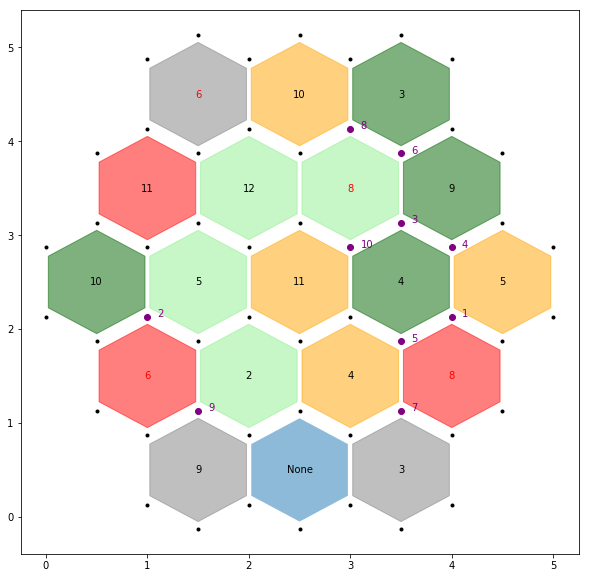

In [46]:
brd = Board.random()
# brd.settle(5, 3, 'blue')
brd.plot()
brd.plot_best(10)

In [40]:
tiles = [
    Tile(2, 0, 'clay', 9),
    Tile(4, 0, 'wood', 10),
    Tile(6, 0, 'wheat', 8),
    Tile(1, 1, 'wood', 12),
    Tile(3, 1, 'wheat', 5),
    Tile(5, 1, 'sheep', 4),
    Tile(7, 1, 'sheep', 3),
    Tile(0, 2, 'desert'),
    Tile(2, 2, 'clay', 6),
    Tile(4, 2, 'rock', 3),
    Tile(6, 2, 'wheat', 9),
    Tile(8, 2, 'wood', 6),
    Tile(1, 3, 'sheep', 11),
    Tile(3, 3, 'wheat', 4),
    Tile(5, 3, 'clay', 11),
    Tile(7, 3, 'rock', 2),
    Tile(2, 4, 'wood', 8),
    Tile(4, 4, 'rock', 10),
    Tile(6, 4, 'sheep', 5)
]
tiles = [
    Tile(2, 0, 'wheat', 12),
    Tile(4, 0, 'rock', 9),
    Tile(6, 0, 'wheat', 10),
    Tile(1, 1, 'wood', 11),
    Tile(3, 1, 'sheep', 6),
    Tile(5, 1, 'clay', 5),
    Tile(7, 1, 'wood', 8),
    Tile(0, 2, 'sheep', 4),
    Tile(2, 2, 'wheat', 3),
    Tile(4, 2, 'rock', 11),
    Tile(6, 2, 'sheep', 4),
    Tile(8, 2, 'clay', 3),
    Tile(1, 3, 'wood', 8),
    Tile(3, 3, 'clay', 10),
    Tile(5, 3, 'wood', 9),
    Tile(7, 3, 'rock', 6),
    Tile(2, 4, 'wheat', 5),
    Tile(4, 4, 'sheep', 2),
    Tile(6, 4, 'desert')
]
tiles = [
    Tile(2, 0, 'wheat', 8),
    Tile(4, 0, 'wood', 4),
    Tile(6, 0, 'wheat', 11),
    Tile(1, 1, 'wheat', 10),
    Tile(3, 1, 'sheep', 11),
    Tile(5, 1, 'rock', 3),
    Tile(7, 1, 'rock', 12),
    Tile(0, 2, 'wood', 5),
    Tile(2, 2, 'wood', 9),
    Tile(4, 2, 'desert'),
    Tile(6, 2, 'wheat', 6),
    Tile(8, 2, 'clay', 9),
    Tile(1, 3, 'clay', 2),
    Tile(3, 3, 'sheep', 4),
    Tile(5, 3, 'wood', 5),
    Tile(7, 3, 'clay', 10),
    Tile(2, 4, 'sheep', 6),
    Tile(4, 4, 'rock', 3),
    Tile(6, 4, 'sheep', 8)
]
brd = Board(tiles)

In [41]:
brd.settle(7, 2, 'blue')
brd.settle(4, 1, 'red')

In [42]:
brd.all_potentials(7, 2)

{(6, 2): 0.0, (7, 1): 6.418666666666667, (8, 2): 11.358333333333333}

In [43]:
brd.best().sum()

pips                                                           283
relpips                                                    2.5e+02
ave_potential                                              3.7e+02
blocking                                                   2.4e+02
total                                                      1.1e+03
tiles            clay 10 clay 9 wheat 6clay 10 wood 5 wheat 6sh...
dtype: object

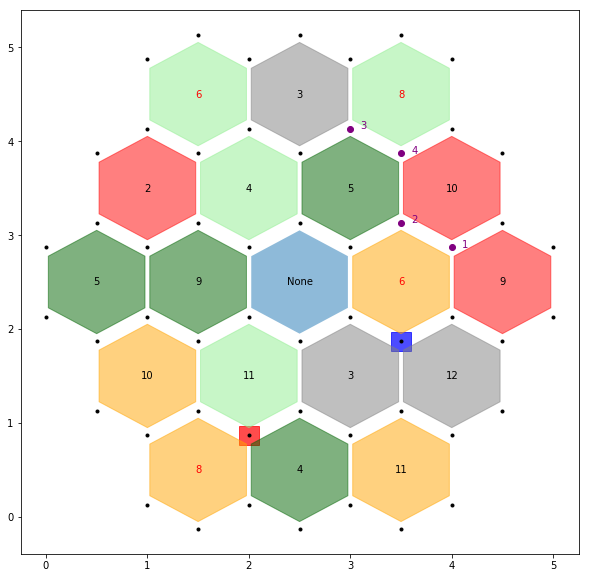

In [15]:
brd.plot()
brd.plot_best(4)

In [16]:
list(brd.tiles.roll(3))

[Tile(@(5,1) rock 3), Tile(@(4,4) rock 3)]